In [129]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report, pairwise_distances

In [130]:
file_path = "accepted_clean_modelreq.csv"
df = pd.read_csv(file_path)
df = df.iloc[1:10000, :]
df.drop(columns=['emp_title'], inplace=True)

In [131]:
good_status = ['Fully Paid']
bad_status = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off']

df['target'] = df['loan_status'].isin(bad_status).astype(int)
df.drop(columns=['loan_status'], inplace=True)

In [132]:
X = df.drop("target", axis=1)
y = df['target']

In [133]:
cat_cols = ['home_ownership', 'verification_status', 'purpose', 'application_type']
num_cols = ['loan_amnt', 'term', 'installment', 'grade', 'emp_length', 
       'annual_inc', 'zip_code', 'dti', 'mths_since_last_delinq', 'mths_since_last_record',
       'pub_rec', 'total_acc']

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train_proc = preprocess.fit_transform(X_train)
X_test_proc = preprocess.transform(X_test)

smote = SMOTE(random_state=42)
X_train_proc, y_train = smote.fit_resample(X_train_proc, y_train)

In [135]:
print(y_train.value_counts())

train_set = pd.concat([X_train, y_train], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

target
0    5800
1    5800
Name: count, dtype: int64


In [136]:
model = xgb.XGBClassifier(
    objective="binary:logistic",
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric="logloss",
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

model.fit(
    X_train_proc, y_train
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [137]:
y_pred = model.predict(X_test_proc)
y_pred_proba = model.predict_proba(X_test_proc)[:, 1]

In [138]:
print(classification_report(y_test, y_pred))
print(f"Test Data Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2486
           1       0.35      0.26      0.30       514

    accuracy                           0.79      3000
   macro avg       0.60      0.58      0.59      3000
weighted avg       0.77      0.79      0.78      3000

Test Data Accuracy: 0.7907
ROC: 0.6759


In [139]:
sim_df = pd.read_csv(file_path)
good_status = ['Fully Paid']
bad_status = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off']

sim_df = sim_df.iloc[1:10000, :]
sim_df['target'] = sim_df['loan_status'].isin(bad_status).astype(int)
sim_df.drop(columns=['loan_status'], inplace=True)

In [140]:
sim_X = sim_df.drop(columns=["target"])
sim_y = sim_df["target"]

cat_cols = ['home_ownership', 'verification_status', 'purpose', 'application_type']
num_cols = ['loan_amnt', 'term', 'installment', 'grade', 'emp_length', 
       'annual_inc', 'zip_code', 'dti', 'mths_since_last_delinq', 'mths_since_last_record',
       'pub_rec', 'total_acc']

In [141]:
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

In [142]:
sim_X_train, sim_X_test, sim_y_train, sim_y_test = train_test_split(
    sim_X, sim_y, test_size=0.3, stratify=sim_y, random_state=42
)

sim_X_train_proc = preprocess.fit_transform(sim_X_train)
sim_X_test_proc = preprocess.transform(sim_X_test)
sim_X_train_proc

array([[ 0.55581603,  1.54310059,  0.45820227, ...,  0.        ,
         1.        ,  0.        ],
       [-0.59448566, -0.64804589, -0.35335657, ...,  0.        ,
         1.        ,  0.        ],
       [-1.05460634, -0.64804589, -1.02451866, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.16963651, -0.64804589, -1.09527671, ...,  0.        ,
         1.        ,  0.        ],
       [-1.05460634, -0.64804589, -1.03547216, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.55581603, -0.64804589,  0.67959102, ...,  0.        ,
         1.        ,  0.        ]], shape=(6999, 32))

In [143]:
smote = SMOTE(random_state=42)
sim_X_train_proc, sim_y_train = smote.fit_resample(sim_X_train_proc, sim_y_train)

In [144]:
bad_mask = (sim_y_train == 1)
sim_X_bad = sim_X_train_proc[bad_mask]

# Generating similarity feature, Calculating the distances to bad targets (Charging Off, Failed to Meet Credit Policy, etc.)
# Use K = 20 as boundary.

def similarity_features(sim_X_new_proc):
    dist_matrix = pairwise_distances(sim_X_new_proc, sim_X_bad, metric="euclidean")
    min_dist = dist_matrix.min(axis=1)
    mean_dist = dist_matrix.mean(axis=1)
    # Top-K Neighbor's Charge Off Probability
    k = 20
    topk_idx = np.argsort(dist_matrix, axis=1)[:, :k]
    topk_bad_rate = np.array([
        sim_y_train[bad_mask].iloc[idx].mean() for idx in topk_idx
    ])
    return np.vstack([min_dist, mean_dist, topk_bad_rate]).T

print("--------------Generating Similarity Features...-----------------")
sim_train = similarity_features(sim_X_train_proc)
sim_test = similarity_features(sim_X_test_proc)
print("---------------Similarity Features Generated.-------------------")

--------------Generating Similarity Features...-----------------
---------------Similarity Features Generated.-------------------


In [145]:
sim_X_train_proc

array([[ 0.55581603,  1.54310059,  0.45820227, ...,  0.        ,
         1.        ,  0.        ],
       [-0.59448566, -0.64804589, -0.35335657, ...,  0.        ,
         1.        ,  0.        ],
       [-1.05460634, -0.64804589, -1.02451866, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.19652991, -0.64804589,  0.0312401 , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.11598043, -0.64804589,  1.42790811, ...,  0.        ,
         1.        ,  0.        ],
       [-0.14431434, -0.64804589, -0.04390209, ...,  0.        ,
         1.        ,  0.        ]], shape=(11600, 32))

In [149]:
sim_X_train_aug = np.hstack([sim_X_train_proc, sim_train])
sim_X_test_aug = np.hstack([sim_X_test_proc, sim_test])

# -------------------------------
# XGBoost Model
# -------------------------------
sim_model = xgb.XGBClassifier(
    objective="binary:logistic",
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric="logloss",
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

sim_model.fit(sim_X_train_aug, sim_y_train)

# -------------------------------
# Model Assessment
# -------------------------------
sim_y_pred = sim_model.predict(sim_X_test_aug)
sim_y_pred_proba = sim_model.predict_proba(sim_X_test_aug)[:, 1]
roc = roc_auc_score(sim_y_test, sim_y_pred_proba)

print(f"ROC AUC: {roc:.3f}")
print(classification_report(sim_y_test, sim_y_pred))
print(f"Test Data Accuracy: {accuracy_score(sim_y_test, sim_y_pred):.4f}")
print(f"ROC: {roc_auc_score(sim_y_test, sim_y_pred_proba):.4f}")

ROC AUC: 0.689
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2486
           1       0.00      0.00      0.00       514

    accuracy                           0.83      3000
   macro avg       0.41      0.50      0.45      3000
weighted avg       0.69      0.83      0.75      3000

Test Data Accuracy: 0.8280
ROC: 0.6887


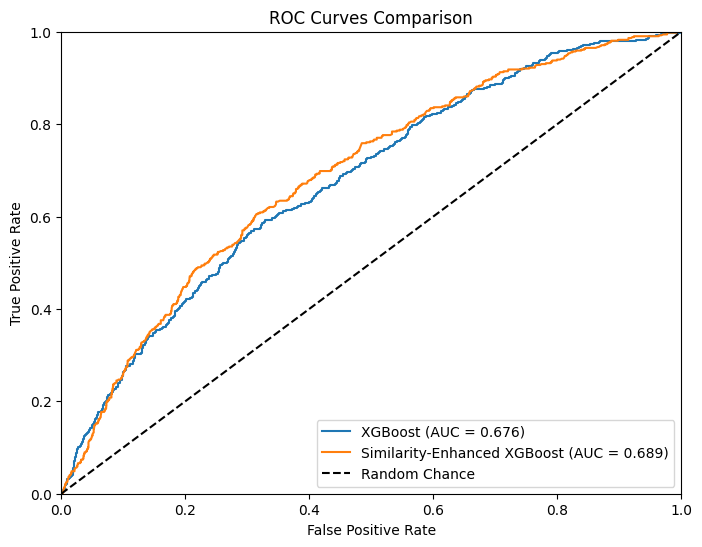

In [150]:
models = {
    "XGBoost": (y_pred_prob, y_pred),
    "Similarity-Enhanced XGBoost": (sim_y_pred_proba, sim_y_pred)
}
plt.figure(figsize=(8, 6))

for name, (y_pred_proba, y_pred) in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc = "lower right")
plt.show()

In [151]:
sim_X_train_aug

array([[ 0.55581603,  1.54310059,  0.45820227, ...,  2.15946766,
         5.08212004,  1.        ],
       [-0.59448566, -0.64804589, -0.35335657, ...,  2.28514217,
         4.50639293,  1.        ],
       [-1.05460634, -0.64804589, -1.02451866, ...,  1.47599242,
         4.99313734,  1.        ],
       ...,
       [-0.19652991, -0.64804589,  0.0312401 , ...,  0.        ,
         4.10193051,  1.        ],
       [ 1.11598043, -0.64804589,  1.42790811, ...,  0.        ,
         4.77814845,  1.        ],
       [-0.14431434, -0.64804589, -0.04390209, ...,  0.        ,
         4.30739035,  1.        ]], shape=(11600, 35))

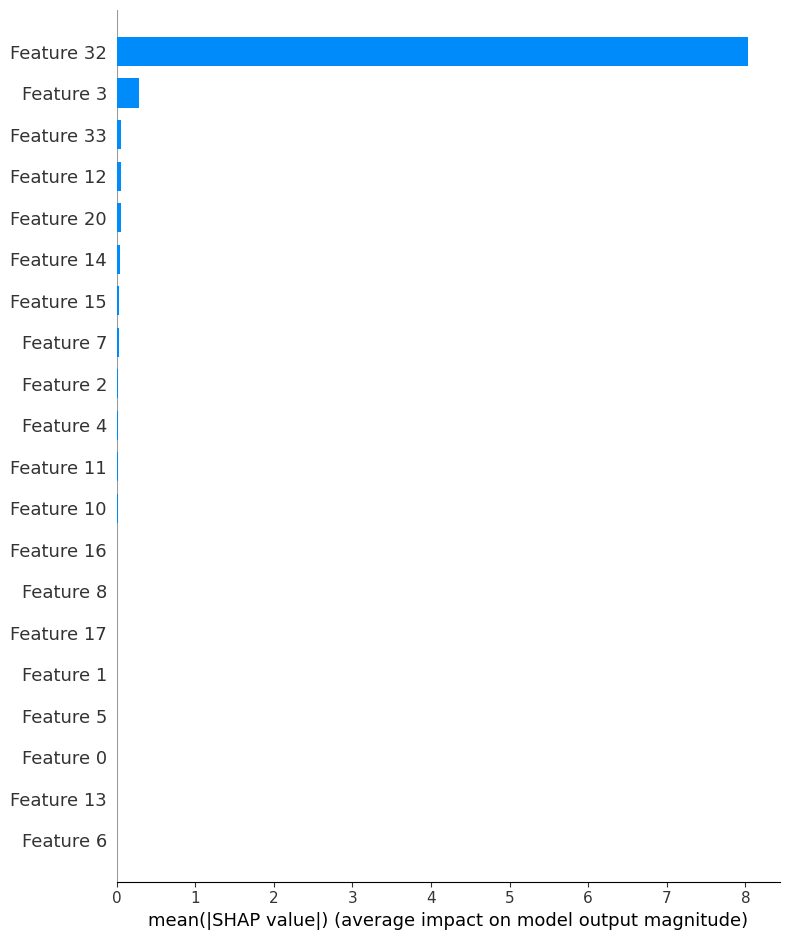

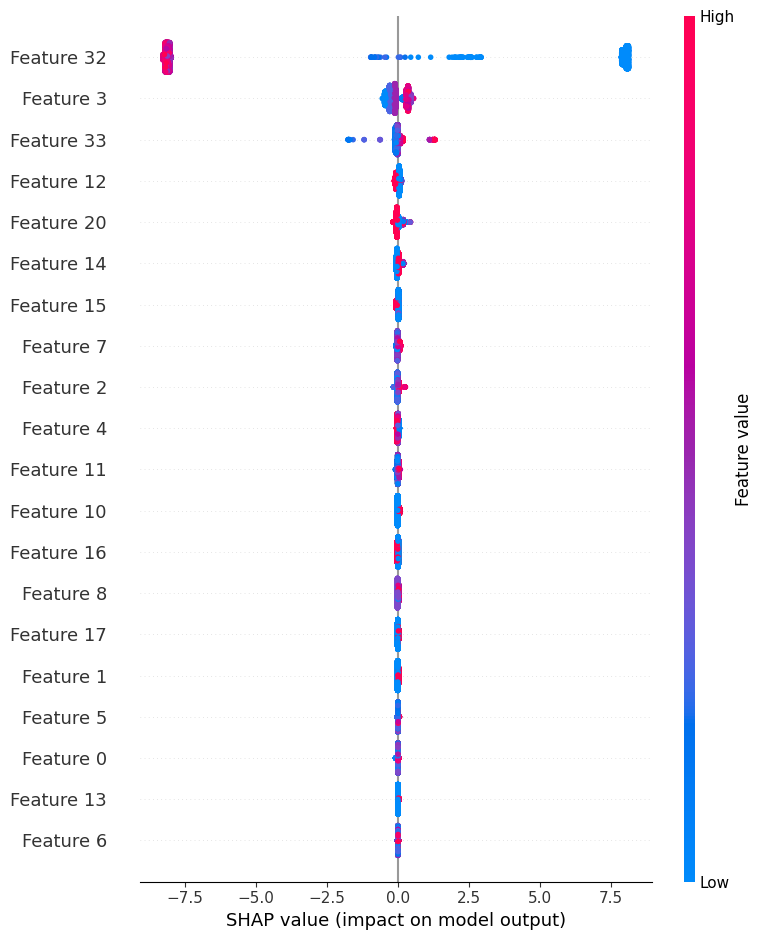

In [152]:
shap.initjs()

explainer = shap.TreeExplainer(sim_model)
sample = sim_X_train_aug
shap_values = explainer.shap_values(sim_X_train_aug)

shap.summary_plot(shap_values, sim_X_train_aug, plot_type="bar")
shap.summary_plot(shap_values, sim_X_train_aug)

根据相似度判断违约风险以XGBoost模型为基础，通过计算距离训练集中违约人特征较近的人，从而在已有的特征基础上添加相似度特征，并将修改后的特征再次通过XGBoost模型进行分类，与修改前的特征进行对比。由于内存消耗和计算时间的制约，本模型使用数据集中前10000条数据进行训练和测试。
在测试集中，添加相似度特征的模型在识别准确率上相较于未添加相似度特征的模型有所提升（0.791至0.828)，但AUC值仅略微提升1%至2%。
由于数据处理过程中使用了ColumnTransformer进行了特征变换，因此SHAP图中的特征名称均被去除。不过相似度特征为Feature 32 - Feature 34。因此可以从图中得出相似度特征对模型分类的影响较大。